In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import ast
import random
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

advan_fairfax_path = 'data/Atlanta_data/advan_atlanta.csv'
acs_fairfax_path = 'data/Atlanta_data/ACS_atlanta/ACSDT5Y2018.B01001-Data.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
advan_data = pd.read_csv(advan_fairfax_path)
acs_data = pd.read_csv(acs_fairfax_path)
# Remove the first row as it contains explanations for each column
acs_data = acs_data.iloc[1:]

# Preprocess ACS data to get age group distribution per CBG
acs_data = acs_data.rename(columns={'GEO_ID': 'cbg'})
acs_data['cbg'] = acs_data['cbg'].str[-12:]

In [20]:
from scipy.stats import zscore
broad_age_groups = {
    'Youth (0-20)': ['B01001_003E', 'B01001_027E', 'B01001_004E', 'B01001_028E',  # 00 - 09 years
                      'B01001_005E', 'B01001_029E', 'B01001_006E', 'B01001_030E', 'B01001_007E', 'B01001_031E',  # 10 - 19 years
                      'B01001_008E', 'B01001_032E'],  # Only 20 years

    'Adults (21-59)': ['B01001_009E', 'B01001_033E', 'B01001_010E', 'B01001_034E', 'B01001_011E', 'B01001_035E',  # 21-29
                        'B01001_012E', 'B01001_036E', 'B01001_013E', 'B01001_037E',  # 30-39
                        'B01001_014E', 'B01001_038E', 'B01001_015E', 'B01001_039E',  # 40-49
                        'B01001_016E', 'B01001_040E', 'B01001_017E', 'B01001_041E'],  # 50-59

    'Elders (60+)': ['B01001_018E', 'B01001_042E', 'B01001_019E', 'B01001_043E', 'B01001_020E', 'B01001_044E', 
                     'B01001_021E', 'B01001_045E', 'B01001_022E', 'B01001_046E', 'B01001_023E', 'B01001_047E', 
                     'B01001_024E', 'B01001_048E', 'B01001_025E', 'B01001_049E']  # 60+
}

age_group_populations = {}
for group, columns in broad_age_groups.items():
    acs_data[group] = acs_data[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    age_group_populations[group] = acs_data.groupby('cbg')[group].sum()

acs_age_distribution = pd.DataFrame(age_group_populations)
acs_age_distribution.reset_index(inplace=True)

# Normalize to get proportion of each age group per CBG
age_group_columns = list(broad_age_groups.keys())
acs_age_distribution[age_group_columns] = acs_age_distribution[age_group_columns].div(acs_age_distribution[age_group_columns].sum(axis=1), axis=0).fillna(0)

# Compute z-scores for each broad age group
z_scores_broad = acs_age_distribution[list(broad_age_groups.keys())].apply(zscore)

# Identify CBGs with extreme distributions
extreme_cbgs_broad = acs_age_distribution[(z_scores_broad.abs() > 2).any(axis=1)]
print(extreme_cbgs_broad)

               cbg  Youth (0-20)  Adults (21-59)  Elders (60+)
2     130630402031      0.129098        0.854508      0.016393
15    130630403035      0.476471        0.352941      0.170588
17    130630403061      0.476525        0.468627      0.054849
49    130630404171      0.465462        0.515409      0.019129
50    130630404172      0.514196        0.335962      0.149842
...            ...           ...             ...           ...
1470  131350503102      0.050725        0.425121      0.524155
1474  131350503131      0.480405        0.443742      0.075853
1506  131350504152      0.084034        0.458583      0.457383
1603  131350505312      0.494441        0.460534      0.045025
1693  131350507204      0.197216        0.432328      0.370456

[185 rows x 4 columns]


In [21]:
sub_data = acs_age_distribution[['Youth (0-20)', 'Elders (60+)']]
sub_data

,Youth (0-20),Elders (60+)
0,0.369303,0.075067
1,0.377544,0.093333
2,0.129098,0.016393
3,0.281370,0.081946
4,0.390339,0.066630
...,...,...
1718,0.324407,0.122712
1719,0.333155,0.117836
1720,0.314132,0.125142
1721,0.340071,0.156491


In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of clusters (you can tune this value)
num_clusters = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
acs_age_distribution['cluster'] = kmeans.fit_predict(sub_data)


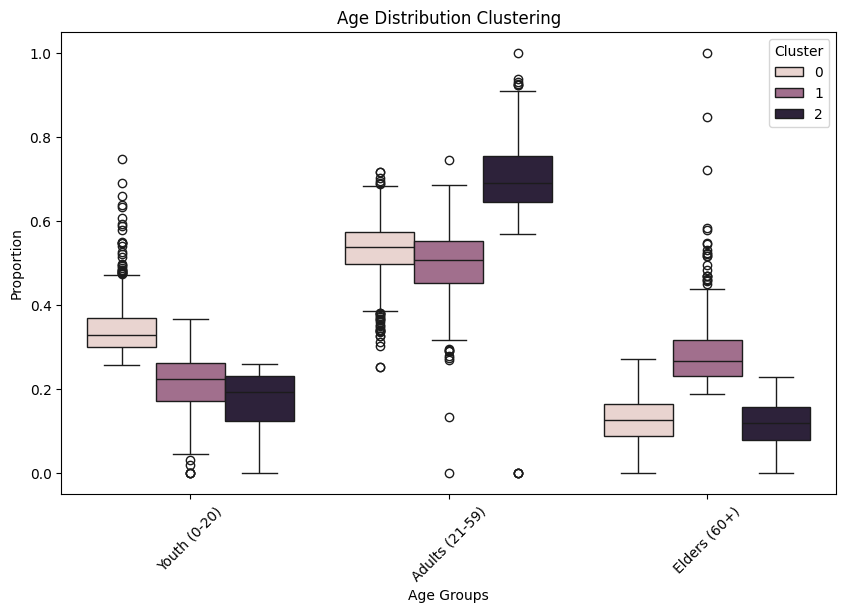

In [23]:

# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.boxplot(data=acs_age_distribution.melt(id_vars=['cluster'], value_vars=age_group_columns),
            x='variable', y='value', hue='cluster')
plt.title('Age Distribution Clustering')
plt.xlabel('Age Groups')
plt.ylabel('Proportion')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

In [24]:
acs_age_distribution[['Youth (0-20)', 'Elders (60+)']].shape

(1723, 2)

In [26]:
# Compute distances to cluster centroids
centroids = kmeans.cluster_centers_
acs_age_distribution['Distance'] = np.linalg.norm(acs_age_distribution[['Youth (0-20)', 'Elders (60+)']].values - centroids[acs_age_distribution['cluster']], axis=1)

# Define outliers: Points with distances greater than a chosen threshold (e.g., top 5%)
threshold = np.percentile(acs_age_distribution['Distance'], 80)  # Adjust as needed
acs_age_distribution['Outlier'] = acs_age_distribution['Distance'] > threshold

outliers_cbg = acs_age_distribution[acs_age_distribution['Outlier'] == True]['cbg']
outliers_cbg

2       130630402031
7       130630403021
9       130630403023
15      130630403035
17      130630403061
            ...     
1630    131350505413
1634    131350505441
1647    131350505483
1678    131350507134
1682    131350507152
Name: cbg, Length: 345, dtype: object

In [27]:
age_groups = {
    '00 - 09 years': ['B01001_003E', 'B01001_027E', 'B01001_004E', 'B01001_028E'], 
    '10 - 19 years': ['B01001_005E', 'B01001_029E', 'B01001_006E', 'B01001_030E', 'B01001_007E', 'B01001_031E'], 
    '20 - 29 years': ['B01001_008E', 'B01001_032E', 'B01001_009E', 'B01001_033E', 'B01001_010E', 'B01001_034E', 'B01001_011E', 'B01001_035E'], 
    '30 - 39 years': ['B01001_012E', 'B01001_036E', 'B01001_013E', 'B01001_037E'], 
    '40 - 49 years': ['B01001_014E', 'B01001_038E', 'B01001_015E', 'B01001_039E'], 
    '50 - 59 years': ['B01001_016E', 'B01001_040E', 'B01001_017E', 'B01001_041E'], 
    '60 + years': ['B01001_018E', 'B01001_042E', 'B01001_019E', 'B01001_043E', 'B01001_020E', 'B01001_044E', 'B01001_021E', 'B01001_045E', 
                   'B01001_022E', 'B01001_046E', 'B01001_023E', 'B01001_047E', 'B01001_024E', 'B01001_048E', 'B01001_025E', 'B01001_049E']
}

In [28]:
age_group_populations = {}
for group, columns in age_groups.items():
    acs_data[group] = acs_data[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    age_group_populations[group] = acs_data.groupby('cbg')[group].sum()

acs_age_distribution = pd.DataFrame(age_group_populations)
acs_age_distribution.reset_index(inplace=True)

# Normalize to get proportion of each age group per CBG
age_group_columns = list(age_groups.keys())
acs_age_distribution[age_group_columns] = acs_age_distribution[age_group_columns].div(acs_age_distribution[age_group_columns].sum(axis=1), axis=0).fillna(0)

In [29]:
print(acs_age_distribution)

               cbg  00 - 09 years  10 - 19 years  20 - 29 years  \
0     130630402021       0.185657       0.178284       0.295576   
1     130630402022       0.251228       0.111579       0.167018   
2     130630402031       0.061475       0.067623       0.327869   
3     130630402032       0.163572       0.088988       0.206786   
4     130630402041       0.232649       0.137701       0.243198   
...            ...            ...            ...            ...   
1718  131350507292       0.088814       0.226780       0.129153   
1719  131350507301       0.143010       0.181039       0.075790   
1720  131350507302       0.174518       0.139614       0.129682   
1721  131350507311       0.147322       0.185039       0.163784   
1722  131350507312       0.133321       0.142908       0.114326   

      30 - 39 years  40 - 49 years  50 - 59 years  60 + years  
0          0.099866       0.108579       0.056971    0.075067  
1          0.104561       0.157193       0.115088    0.093333  
2  

In [30]:
# Preprocess Advan data to get visitation distribution by CBG for each POI
advan_data = advan_data.rename(columns={'placekey': 'poi_id', 'visitor_home_cbgs': 'visitor_cbg', 'visits_by_day': 'visits'})

# Parse the 'visitor_cbg' column to convert it from string to dictionary
advan_data['visitor_cbg'] = advan_data['visitor_cbg'].apply(lambda x: ast.literal_eval(str(x)) if pd.notna(x) else {})

In [31]:
advan_data.columns

Index(['poi_id', 'location_name', 'top_category', 'naics_code', 'poi_cbg',
       'visitor_cbg', 'visitor_home_aggregation', 'start_date'],
      dtype='object')

In [32]:
# Construct contact matrices for each POI and week
contact_matrices = {}
visitor_age_distributions ={}
include_cbgs_by_week = {}
include_visitors_by_week = {}
for _, row in advan_data.iterrows():
    poi_id = row['poi_id']
    week = row['start_date'] 
    visitor_cbgs = row['visitor_cbg']

    include_cbg_count = 0
    include_visitors = 0
    
    # Estimate the demographic composition of visitors
    visitor_demographics = pd.Series(0, index=age_groups.keys(), dtype=float)
    for cbg, count in visitor_cbgs.items():
        # if cbg in acs_age_distribution['cbg'].values:
        if cbg in outliers_cbg:
            cbg_age_distribution = acs_age_distribution.loc[acs_age_distribution['cbg'] == cbg, age_group_columns].iloc[0]
            if cbg_age_distribution.sum() > 0:  # Only sample if the population is greater than 0
                sampled_visitors = pd.Series([0] * len(age_group_columns), index=age_group_columns)
                for _ in range(count):                    
                    sampled_age_group = random.choices(age_group_columns, weights=cbg_age_distribution)[0]
                    sampled_visitors[sampled_age_group] += 1
                visitor_demographics += sampled_visitors
            include_cbg_count += 1
            include_visitors += count
        
    if week not in include_cbgs_by_week: 
        include_cbgs_by_week[week] = include_cbg_count
        include_visitors_by_week[week] = include_visitors
    else: 
        include_cbgs_by_week[week] += include_cbg_count
        include_visitors_by_week[week] += include_visitors
    
    # Normalize the visitor demographics
    total_visits = visitor_demographics.sum()
    if total_visits > 0:
        visitor_demographics /= total_visits

    # Store the raw visitor age distribution for this POI and week
    visitor_age_distributions[(poi_id, week)] = visitor_demographics.to_dict()
    
    # Create contact matrix for the POI for the given week
    contact_matrix = pd.DataFrame(0, index=age_groups.keys(), columns=age_groups.keys())
    for age_group_1 in age_groups.keys():
        for age_group_2 in age_groups.keys():
            # Assume interaction rate is proportional to the product of the proportions
            contact_matrix.loc[age_group_1, age_group_2] = (
                visitor_demographics.get(age_group_1, 0) * visitor_demographics.get(age_group_2, 0)
            )
    
    # Store the contact matrix
    contact_matrices[(poi_id, week)] = contact_matrix

In [35]:
import pickle

# Save contact_matrices to a file
with open('atlanta_outlier.pkl', 'wb') as f:
    pickle.dump(contact_matrices, f)

In [ ]:
import pickle
with open('atlanta_outlier.pkl', 'rb') as file:
    contact_matrices = pickle.load(file)

In [33]:
contact_matrix_list = []
for (poi_id, week), matrix in contact_matrices.items():
    contact_matrix_list.append({
        'poi_id': poi_id,
        'week': week,
        'contact_matrix': matrix
})

contact_matrix_df = pd.DataFrame(contact_matrix_list)

In [34]:
# Merge to get 'top_category' only once per POI
contact_matrix_df = contact_matrix_df.merge(advan_data[['poi_id', 'top_category']], on='poi_id', how='left')

In [35]:
df = contact_matrix_df[contact_matrix_df['contact_matrix'].apply(lambda mat: mat.values.sum() > 0)].reset_index(drop=True)

In [36]:
df.size

0

In [ ]:
# Merge to get 'top_category' only once per POI
contact_matrix_df = contact_matrix_df.merge(advan_data[['poi_id', 'top_category']], on='poi_id', how='left')

# Define function to aggregate matrices for a specific category-week pair
def aggregate_matrices(group):
    aggregated_matrix = np.sum(group['contact_matrix'].values, axis=0)
    return (group['top_category'].iloc[0], group['week'].iloc[0], aggregated_matrix)

# Parallel processing for faster aggregation
def parallel_aggregate(df):
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(aggregate_matrices, [group for _, group in df.groupby(['top_category', 'week'])])
    return results

# Run the parallel aggregation
aggregated_results = parallel_aggregate(contact_matrix_df)

# Convert results into a dictionary
category_week_contact_matrices = {(category, week): matrix for category, week, matrix in aggregated_results}

In [ ]:
# Select a top category to visualize all weeks
example_category = "Elementary and Secondary Schools"

# Filter out all contact matrices of the specified category across weeks
category_matrices = {
    week: matrix
    for (category, week), matrix in category_week_contact_matrices.items()
    if category == example_category
}

if category_matrices:
    # Create category_matricesa plot for each week's contact matrix
    num_weeks = len()
    fig, axes = plt.subplots(nrows=num_weeks, figsize=(10, 5 * num_weeks))

    if num_weeks == 1:
        axes = [axes]  # Ensure axes is iterable for single subplot

    for ax, (week, matrix) in zip(axes, category_matrices.items()):
        # Normalize the contact matrix
        normalized_matrix = matrix # / matrix.sum().sum()

        # Plot the normalized contact matrix
        cax = ax.imshow(normalized_matrix, cmap='viridis', aspect='auto')
        for i in range(normalized_matrix.shape[0]):
            for j in range(normalized_matrix.shape[1]):
                ax.text(j, i, f'{normalized_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w')
        ax.set_xticks(np.arange(len(age_groups)))
        ax.set_xticklabels(age_groups.keys(), rotation=90)
        ax.set_yticks(np.arange(len(age_groups)))
        ax.set_yticklabels(age_groups.keys())
        ax.set_title(f"Normalized Contact Matrix for '{example_category}', Week {week}")
        ax.set_xlabel("Age Group")
        ax.set_ylabel("Age Group")
        fig.colorbar(cax, ax=ax, label='Probability')

    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the category '{example_category}'.")

NameError: name 'category_week_contact_matrices' is not defined

In [ ]:
# Trend Analysis for Age Groups in Category Matrices
age_groups_name = list(age_groups.keys())
age_group_pairs = [(i, j) for i in range(len(age_groups_name)) for j in range(i, len(age_groups_name))]
trends = {pair: [] for pair in age_group_pairs}
weeks = sorted(category_matrices.keys())

# Collect trends for each pair of age groups
for week in weeks:
    matrix = category_matrices[week]
    for pair in age_group_pairs:
        trends[pair].append(matrix.iloc[pair[0], pair[1]])

# Plot the trends for selected age-group pairs
selected_pairs = [(0, 0), (0, 6), (3, 3), (6, 6)]  # Example pairs to analyze
plt.figure(figsize=(12, 8))
for pair in age_group_pairs:
    plt.plot(weeks, trends[pair], label=f"{age_groups_name[pair[0]]} ↔ {age_groups_name[pair[1]]}")

# Add plot details
plt.title(f"Trends for Contact Matrix of '{example_category}' Across Weeks")
plt.xlabel("Week")
plt.ylabel("Contact Intensity")
plt.xticks(rotation=45)
plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
# Trend Analysis
age_groups_name = list(age_groups.keys())
age_group_pairs = [(i, j) for i in range(len(age_groups_name)) for j in range(i, len(age_groups_name))]
trends = {}
weeks = []

# Filter for POIs in the "Elementary and Secondary Schools" category
school_pois = advan_data[advan_data['top_category'] == "Elementary and Secondary Schools"]['poi_id'].unique()

# Randomly pick 5 POIs
random.seed(42)
selected_pois = random.sample(list(school_pois), 5)

for poi, week in contact_matrices.keys(): 
    if poi in selected_pois: 
        if poi not in trends: 
            trends[poi] = {pair: [] for pair in age_group_pairs}
        
        for pair in age_group_pairs:
            trends[poi][pair].append(contact_matrices[(poi, week)].iloc[pair[0], pair[1]])
    if week not in weeks: 
        weeks.append(week)
weeks

['2018-01-01',
 '2018-01-08',
 '2018-01-15',
 '2018-01-22',
 '2018-01-29',
 '2018-02-05',
 '2018-02-12',
 '2018-02-19',
 '2018-02-26',
 '2018-03-05',
 '2018-03-12',
 '2018-03-19']

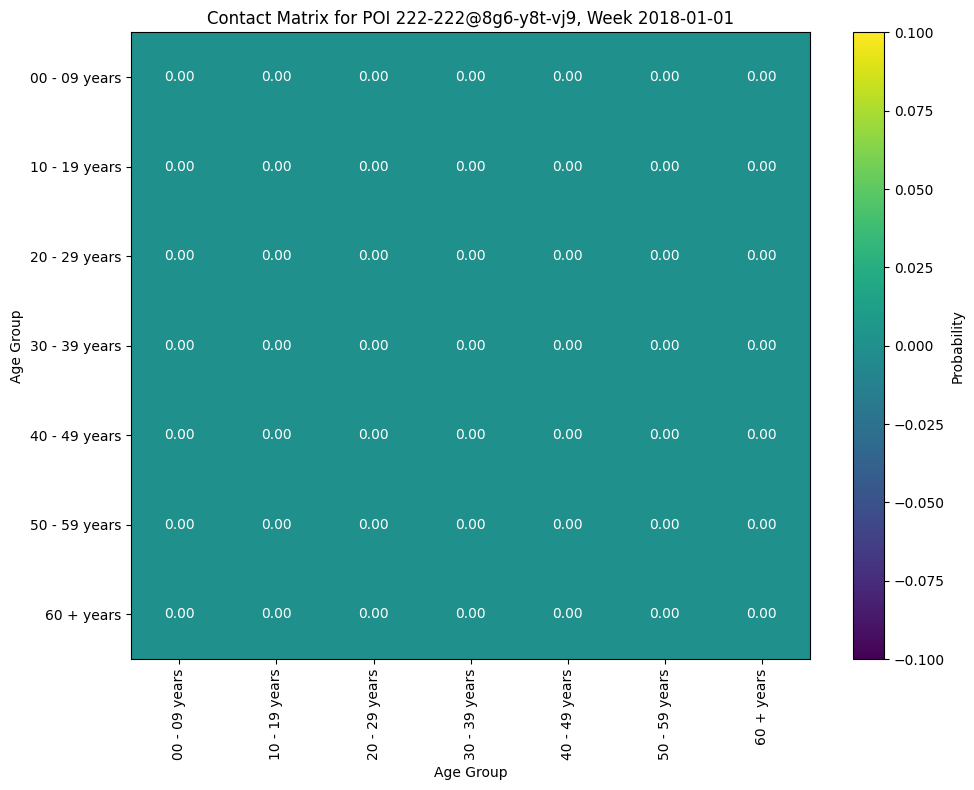

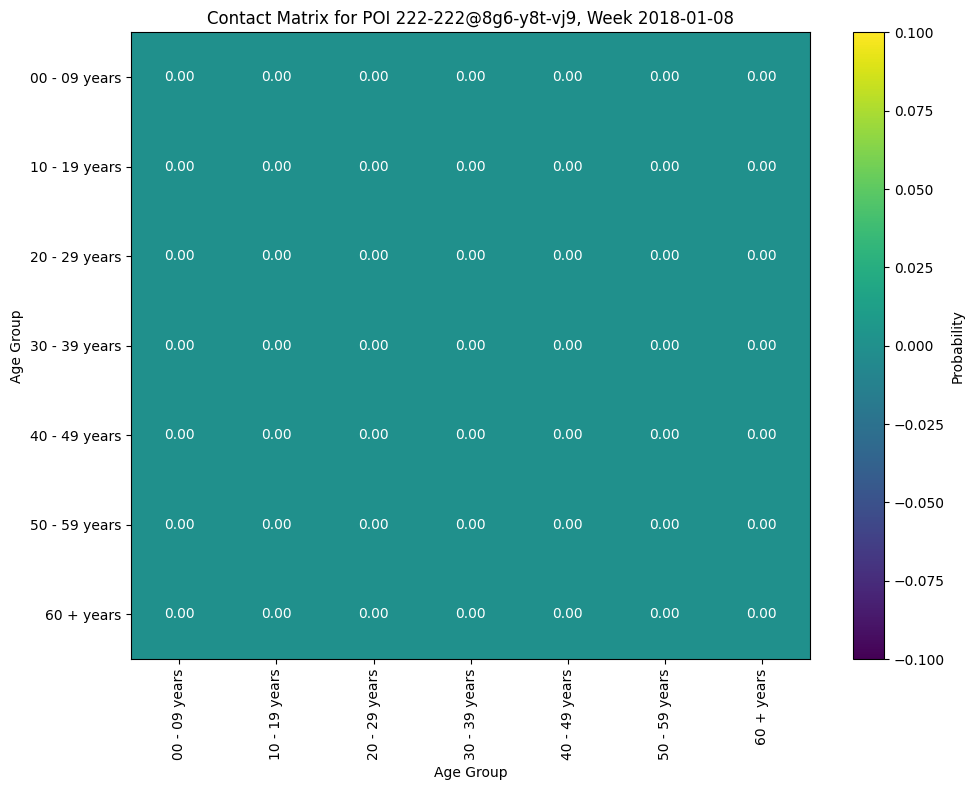

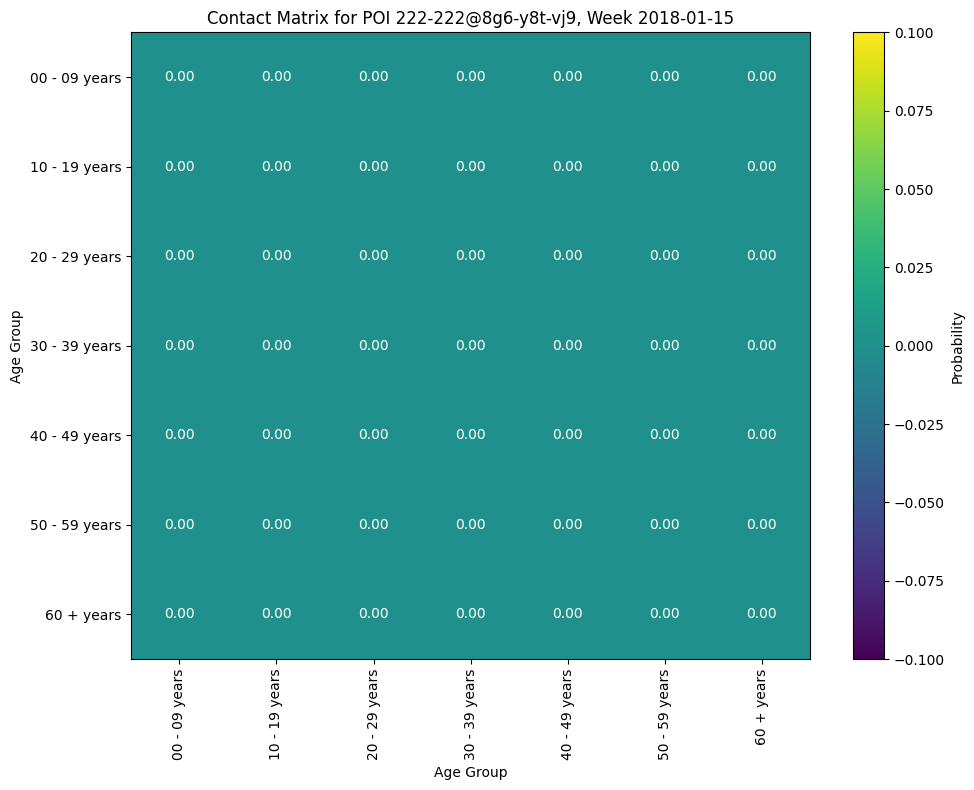

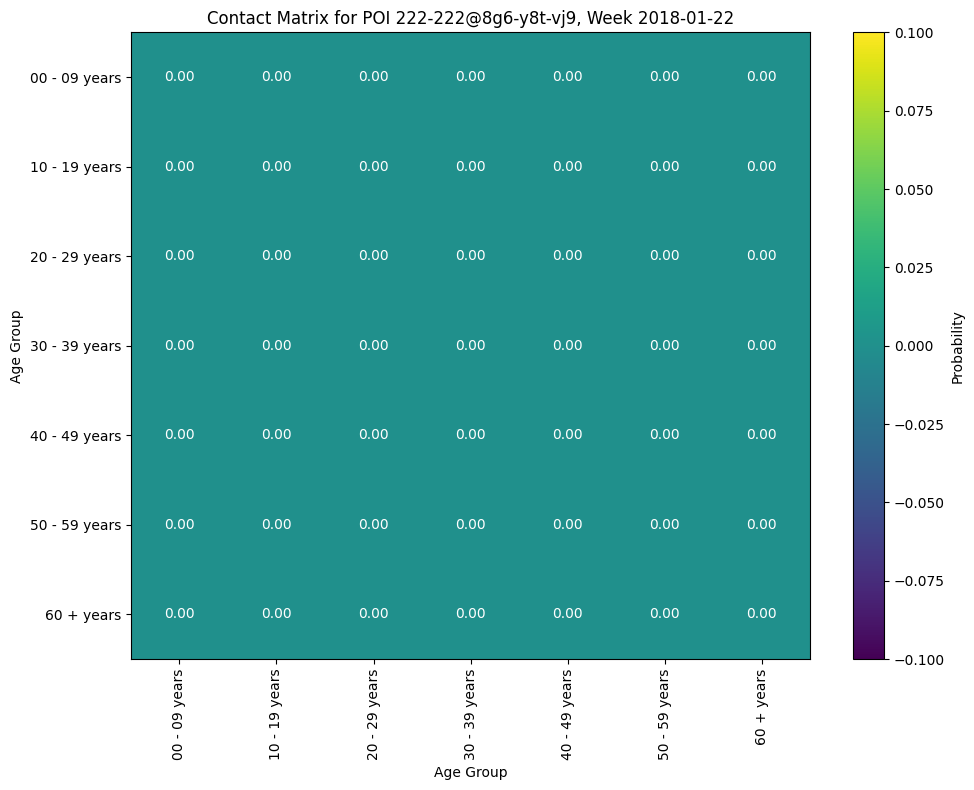

KeyError: ('222-222@8g6-y8t-vj9', '2018-01-29')

In [26]:
for poi in school_pois: 
    for week in weeks: 
        poi_contact_matrix = contact_matrices[(poi, week)]
        plt.figure(figsize=(10, 8))
        plt.imshow(poi_contact_matrix, cmap='viridis', aspect='auto')
        for i in range(poi_contact_matrix.shape[0]):
            for j in range(poi_contact_matrix.shape[1]):
                plt.text(j, i, f'{poi_contact_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w')
        plt.colorbar(label='Probability')
        plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys(), rotation=90)
        plt.yticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys())
        plt.title(f"Contact Matrix for POI {poi}, Week {week}")
        plt.xlabel("Age Group")
        plt.ylabel("Age Group")
        plt.tight_layout()
        plt.show()
    break

In [23]:
for poi in trends.keys(): 
    print(len(trends[poi][pair]))


11
12
12
11
12


C:\Users\james\AppData\Local\Temp\ipykernel_21348\4293368890.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))


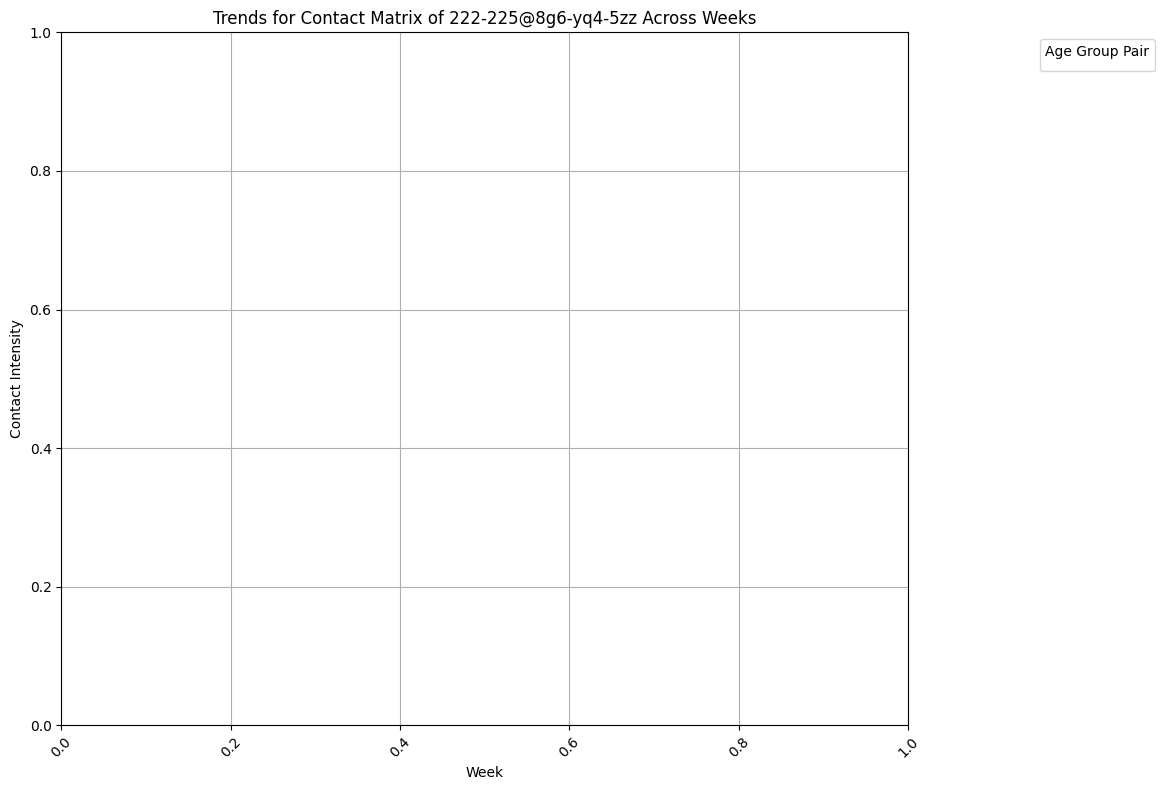

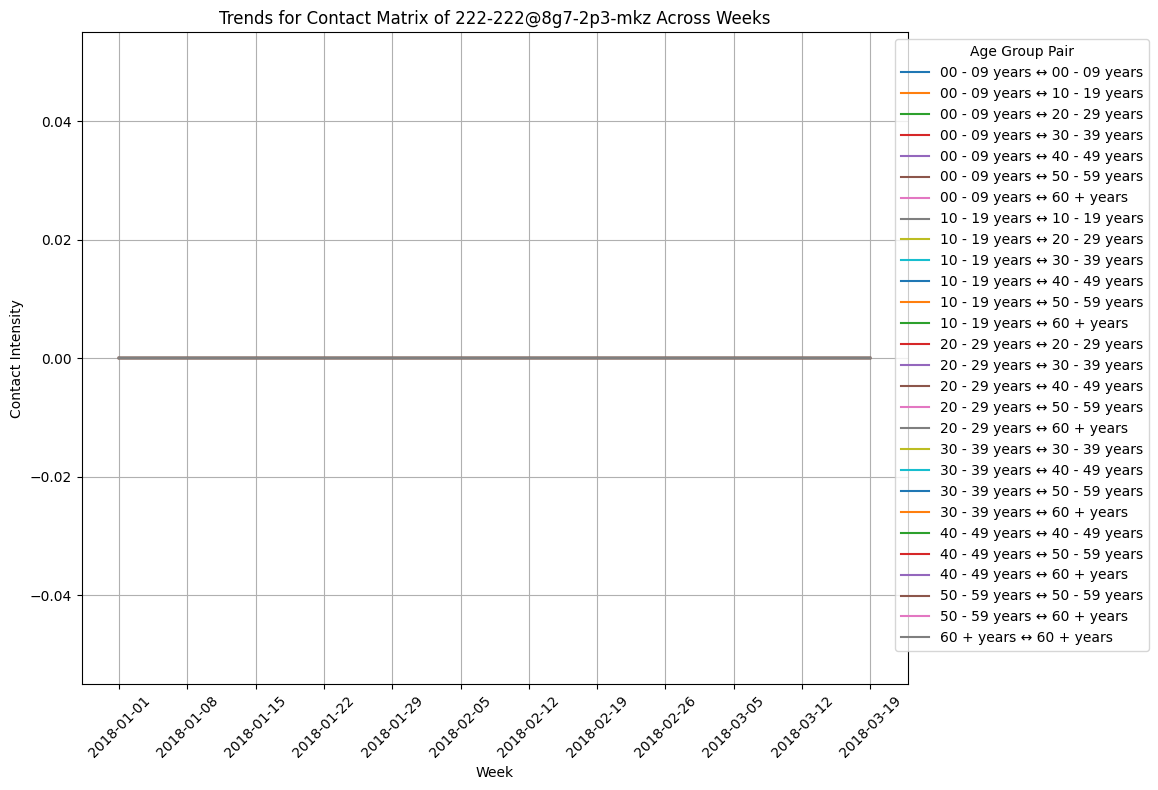

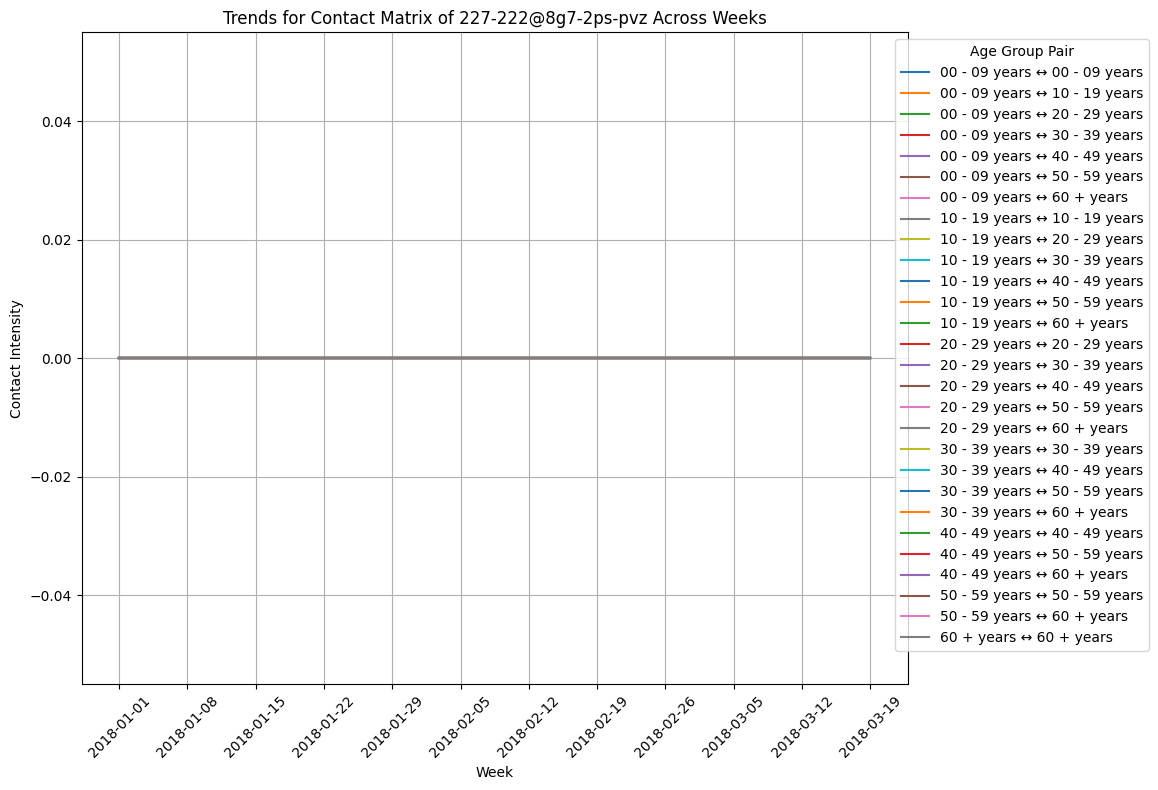

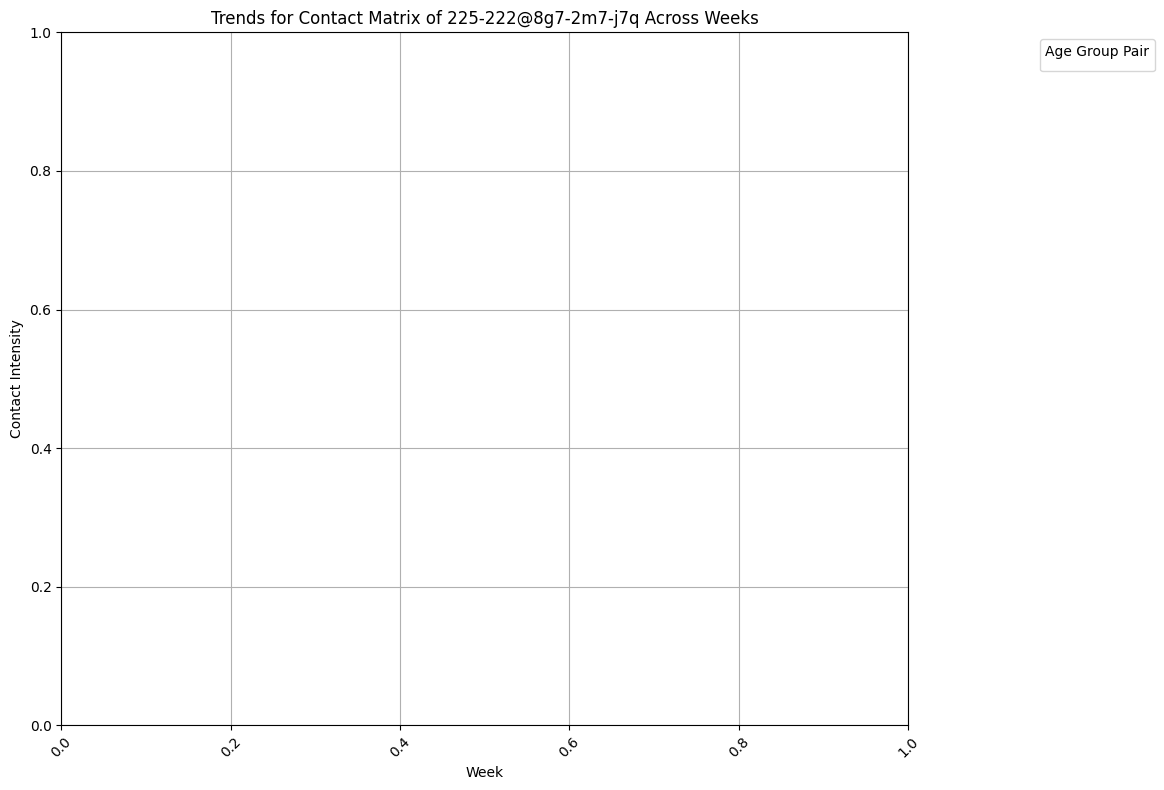

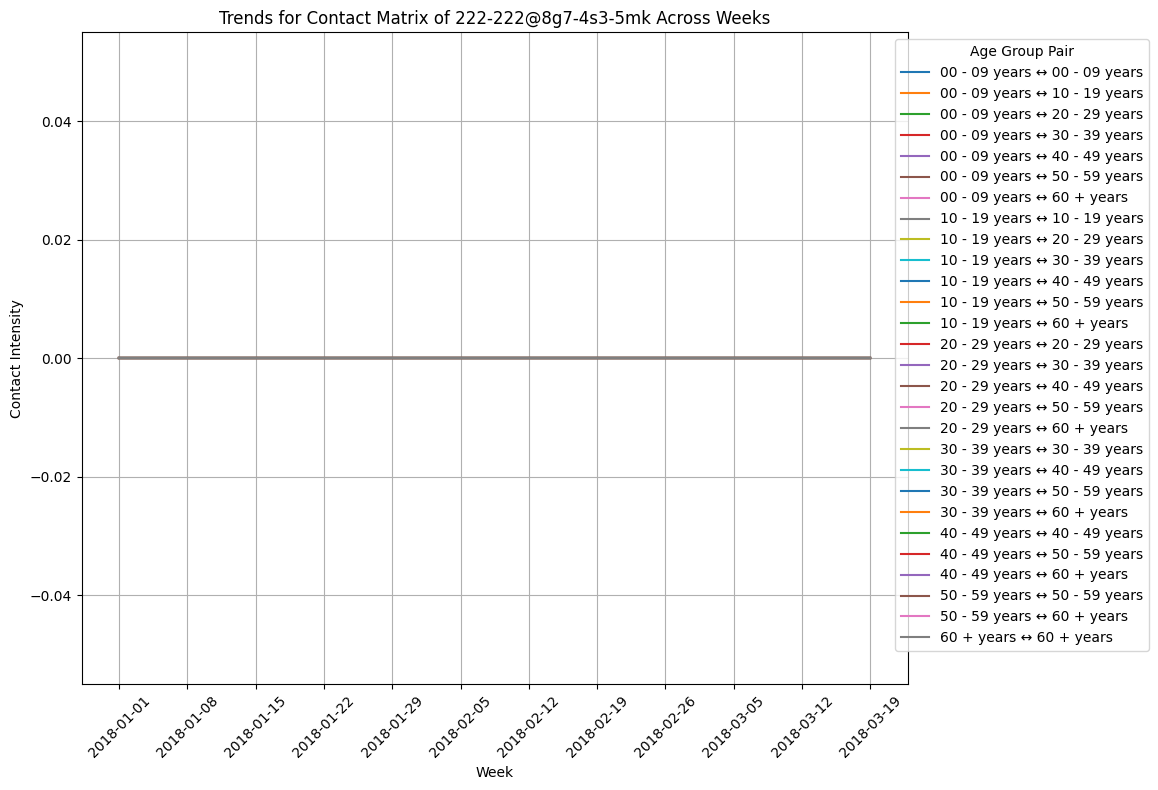

In [24]:
for poi in trends.keys(): 
    
    plt.figure(figsize=(12, 8))
    for pair in age_group_pairs:
        if len(trends[poi][pair]) != len(weeks): 
            continue
        plt.plot(weeks, trends[poi][pair], label=f"{age_groups_name[pair[0]]} ↔ {age_groups_name[pair[1]]}")

    # Add plot details
    plt.title(f"Trends for Contact Matrix of {poi} Across Weeks")
    plt.xlabel("Week")
    plt.ylabel("Contact Intensity")
    plt.xticks(rotation=45)
    plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()